In [93]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from brewer2mpl import qualitative

from task import generate_trials, rule_name, rules_dict, Trial
from network import Model, get_perf
import tools

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def get_model_params(model_dir):

    model = Model(model_dir)
    with tf.Session() as sess:
        model.restore()
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        hparams = model.hp

    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]

    return w_in, b_in, w_out, b_out, hparams

# all rules
rules_dict = \
    {'all' : ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo'],

    'delay' : ['delaygo', 'delayanti',
               'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
               'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo'],
     
    'ndelay' : ['fdgo', 'reactgo', 'fdanti', 'reactanti',
                'dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm']}

In [200]:
model_dir = '/home/laura/code/yangnet/training/data/lowDin/most/0'
model_dir = '/home/laura/code/yangnet/training/data/big_validation/all/0'
# model_dir = '/home/laura/data/multitask/train_all/0'
w_in, _, _, _, hp = get_model_params(model_dir)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(341, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 33) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(33,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/big_validation/all/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/big_validation/all/0/model.ckpt


In [201]:
sa_stim1 = np.zeros((hp['n_eachring'],hp['n_eachring']))
sa_stim2 = np.zeros((hp['n_eachring'],hp['n_eachring']))
sa_rule = np.zeros((len(hp['rule_trains']),len(hp['rule_trains'])))

for stim_ind1 in range(hp['n_eachring']):
    input_ind1 = 1+stim_ind1
    v1 = w_in[input_ind1,:]

    for stim_ind2 in range(hp['n_eachring']):
        input_ind2 = 1+stim_ind2
        v2 = w_in[input_ind2,:]

        sa_stim1[stim_ind1,stim_ind2] = angle_between(v1, v2)

for stim_ind1 in range(hp['n_eachring']):
    input_ind1 = 1+hp['n_eachring']+stim_ind1
    v1 = w_in[input_ind1,:]

    for stim_ind2 in range(hp['n_eachring']):
        input_ind2 = 1+hp['n_eachring']+stim_ind2
        v2 = w_in[input_ind2,:]

        sa_stim2[stim_ind1,stim_ind2] = angle_between(v1, v2)

for rule_ind1 in range(len(hp['rule_trains'])):
    input_ind1 = 1+hp['num_ring']*hp['n_eachring']+rule_ind1
    v1 = w_in[input_ind1,:]

    for rule_ind2 in range(len(hp['rule_trains'])):
        input_ind2 = 1+hp['num_ring']*hp['n_eachring']+rule_ind2
        v2 = w_in[input_ind2,:]

        sa_rule[rule_ind1,rule_ind2] = angle_between(v1, v2)

In [202]:
import matplotlib.colors as mcolors
task_names = hp['rule_trains']

colors = plt.cm.binary(np.linspace(0., 1, 128))
colors = np.vstack((colors[range(127,0,-1),:], colors))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

mean_vec = sa_rule[2,:]
s = np.argsort(abs(mean_vec-np.pi/2))
task_names_sorted = []
for sind in range(0,len(s)):
	task_names_sorted.append(task_names[s[sind]])

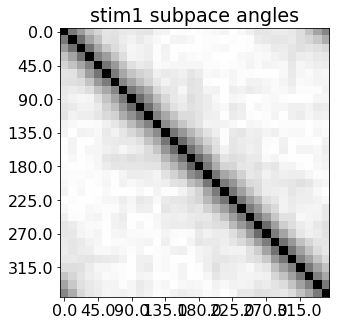

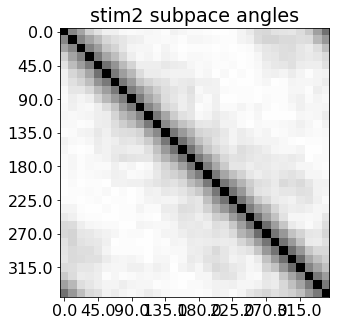

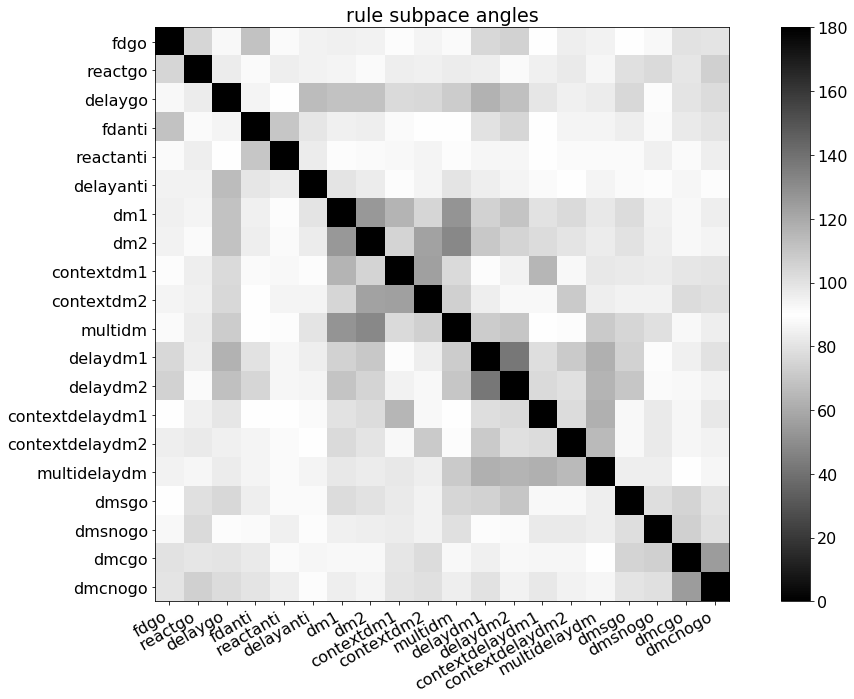

In [203]:
fig = plt.figure(figsize=(5, 5),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

ax = fig.add_subplot(1,1,1)
plt.imshow(np.rad2deg(sa_stim1), vmin=0, vmax=180,cmap = mymap)
ax.set_xticks(range(0,31,4))
ax.set_yticks(range(0,31,4))
ax.set_yticklabels(np.round_(np.linspace(0., 360,9)))
ax.set_xticklabels(np.round_(np.linspace(0., 360,9)))
plt.title('stim1 subpace angles')
    
fig = plt.figure(figsize=(5, 5),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})
ax = fig.add_subplot(1,1,1)
plt.imshow(np.rad2deg(sa_stim2), vmin=0, vmax=180,cmap = mymap)
ax.set_xticks(range(0,31,4))
ax.set_yticks(range(0,31,4))
ax.set_yticklabels(np.round_(np.linspace(0., 360,9)))
ax.set_xticklabels(np.round_(np.linspace(0., 360,9)))
plt.title('stim2 subpace angles')

fig = plt.figure(figsize=(15, 10),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})
ax = fig.add_subplot(1,1,1)
plt.imshow(np.rad2deg(sa_rule),vmin=0, vmax=180,cmap = mymap)
ax.set_xticks(range(0,len(task_names)))
ax.set_yticks(range(0,len(task_names)))
ax.set_yticklabels(task_names)
fig.autofmt_xdate()
ax.set_xticklabels(task_names)
plt.title('rule subpace angles')

cbar = plt.colorbar()

In [204]:
from sklearn.datasets import load_digits
from sklearn.manifold import MDS
from sklearn.manifold import TSNE

embedding = MDS(n_components=2,dissimilarity='precomputed')
X_transformed_mds = embedding.fit_transform(sa_rule)

embedding = TSNE(n_components=2)
X_transformed_tsne = embedding.fit_transform(w_in[(1+hp['num_ring']*hp['n_eachring']):(21+hp['num_ring']*hp['n_eachring']),:])

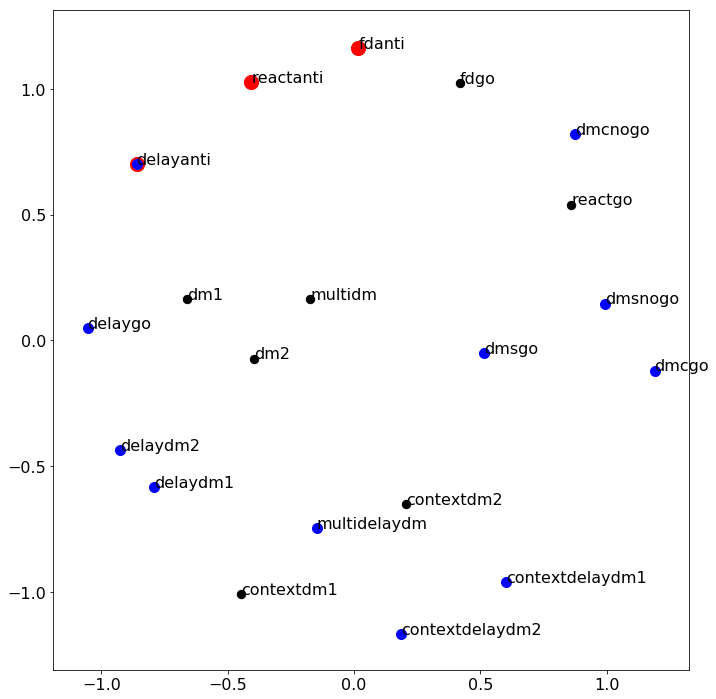

In [206]:
X_transformed = X_transformed_mds

fig = plt.figure(figsize=(10, 10),tight_layout=True,facecolor='white')
plt.scatter(X_transformed[:,0],X_transformed[:,1],s = 70,c = 'k')
plt.scatter(X_transformed[3:6,0],X_transformed[3:6,1],s =200,c = 'r')
delay_tasks = [2,5,11,12,13,14,15,16,17,18,19]
plt.scatter(X_transformed[delay_tasks,0],X_transformed[delay_tasks,1],s = 100,c = 'b')
for r in range(len(task_names)):
    plt.text(X_transformed[r,0],X_transformed[r,1],task_names[r])

In [240]:
# subpace angles on input jacobian
model_dir = '/home/laura/code/yangnet/training/data/lowDin/most/0'
# model_dir = '/home/laura/code/yangnet/training/data/big_validation/all/0'
rule = 'dmsgo'

model = Model(model_dir)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    cell = model.cell

    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    # create a trial
    trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size =1,delay_fac=1)        
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    # run model
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/lowDin/most/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/lowDin/most/0/model.ckpt


In [241]:
print(np.shape(trial.x))


(78, 1, 25)


In [242]:
model = Model(model_dir)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    cell = model.cell

    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    # create a trial
    trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size =1,delay_fac=1)        
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    # run model
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

    states = h_tf[trial.epochs['stim1'][1],0,:]
    cell.inputs = trial.x[trial.epochs['stim1'][1],0,:]
    n_inits = 1

    tiled_inputs = np.tile(cell.inputs, [n_inits, 1])
    inputs_tf = tf.constant(tiled_inputs, dtype=tf.float32)
    cell.inputs_tf = inputs_tf

    tiled_states = np.tile(states, [n_inits, 1])
    states_tf = tf.constant(tiled_states, dtype=tf.float32)

    output, new_states = cell.call(inputs_tf, states_tf)

    J_tf_inputs = pfor.batch_jacobian(new_states, cell.inputs_tf, use_pfor=False)
    J_np_inputs = sess.run(J_tf_inputs)
    print(np.shape(J_np_inputs))

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/lowDin/most/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/lowDin/most/0/model.ckpt
(1, 256, 25)


In [243]:
hp = hparams
task_names = hp['rule_trains']
dFdx = np.squeeze(J_np_inputs)
sa_rule = np.zeros((len(hp['rule_trains']),len(hp['rule_trains'])))

for rule_ind1 in range(len(hp['rule_trains'])):
    input_ind1 = 1+hp['num_ring']*hp['n_eachring']+rule_ind1
    v1 = dFdx[:,input_ind1]

    for rule_ind2 in range(len(hp['rule_trains'])):
        input_ind2 = 1+hp['num_ring']*hp['n_eachring']+rule_ind2
        v2 = dFdx[:,input_ind2]

        sa_rule[rule_ind1,rule_ind2] = angle_between(v1, v2)

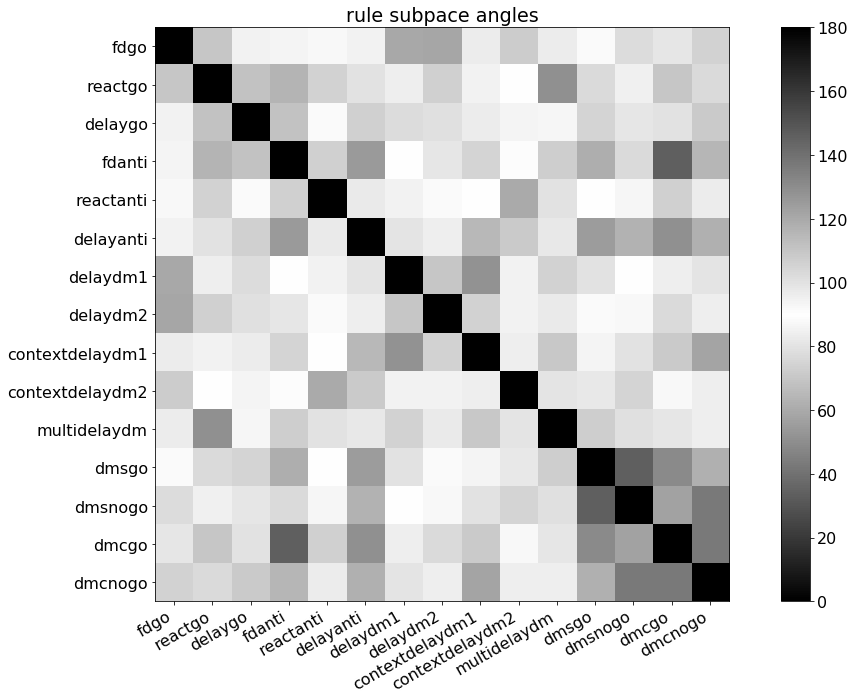

In [244]:
fig = plt.figure(figsize=(15, 10),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})
ax = fig.add_subplot(1,1,1)
plt.imshow(np.rad2deg(sa_rule),vmin=0, vmax=180,cmap = mymap)
ax.set_xticks(range(0,len(task_names)))
ax.set_yticks(range(0,len(task_names)))
ax.set_yticklabels(task_names)
fig.autofmt_xdate()
ax.set_xticklabels(task_names)
plt.title('rule subpace angles')
cbar = plt.colorbar()

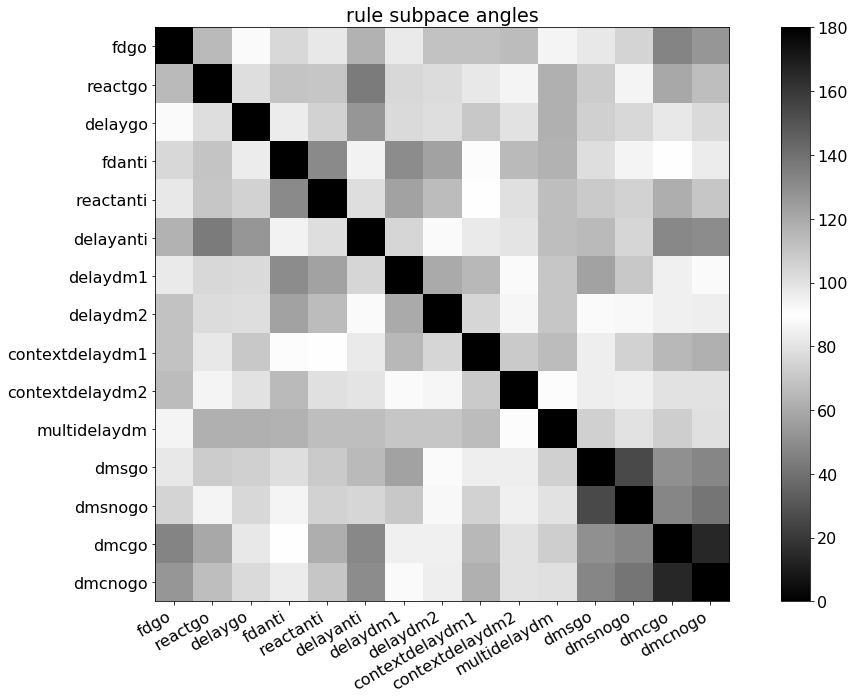

In [239]:
fig = plt.figure(figsize=(15, 10),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})
ax = fig.add_subplot(1,1,1)
plt.imshow(np.rad2deg(sa_rule),vmin=0, vmax=180,cmap = mymap)
ax.set_xticks(range(0,len(task_names)))
ax.set_yticks(range(0,len(task_names)))
ax.set_yticklabels(task_names)
fig.autofmt_xdate()
ax.set_xticklabels(task_names)
plt.title('rule subpace angles')
cbar = plt.colorbar()

In [ ]:
embedding = MDS(n_components=2,dissimilarity='precomputed')
X_transformed_mds = embedding.fit_transform(sa_rule)

embedding = TSNE(n_components=2)
X_transformed_tsne = embedding.fit_transform(w_in[(1+hp['num_ring']*hp['n_eachring']):(21+hp['num_ring']*hp['n_eachring']),:])

(20, 2)


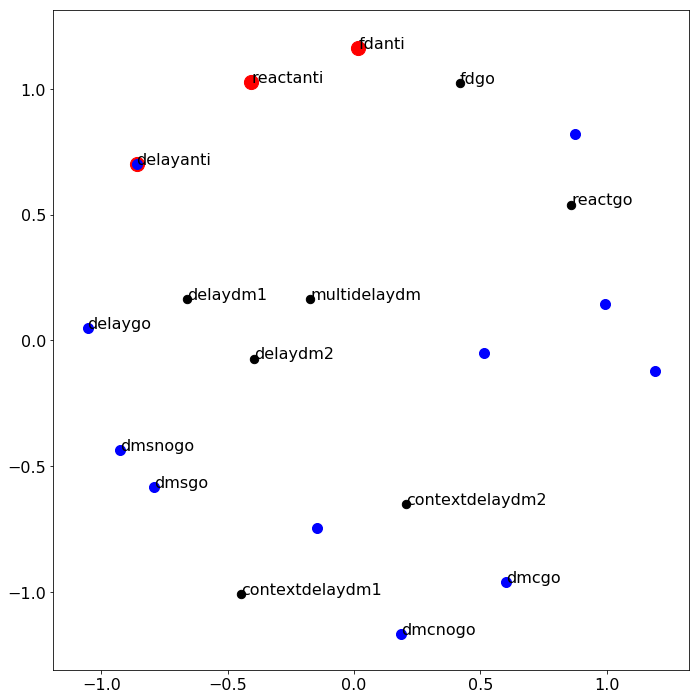

In [246]:
X_transformed = X_transformed_mds

print(np.shape(X_transformed))

fig = plt.figure(figsize=(10, 10),tight_layout=True,facecolor='white')
plt.scatter(X_transformed[:,0],X_transformed[:,1],s = 70,c = 'k')
plt.scatter(X_transformed[3:6,0],X_transformed[3:6,1],s =200,c = 'r')
delay_tasks = [2,5,11,12,13,14,15,16,17,18,19]
plt.scatter(X_transformed[delay_tasks,0],X_transformed[delay_tasks,1],s = 100,c = 'b')
for r in range(len(task_names)):
    plt.text(X_transformed[r,0],X_transformed[r,1],task_names[r])